In [1]:
import json
import pandas as pd

In [2]:
# UniKP
unikp_src = '/home/thomased/work/codebase/coopsummer2023/UniKP/UniKeyphrase/processed/kptimes.test.seq.in'
unikp_p = '/home/thomased/work/codebase/coopsummer2023/UniKP/UniKeyphrase/results/kptimes/kptimes_5ep_b128_l384_ddp_final_Greedy/output_labels'
unikp_a = '/home/thomased/work/codebase/coopsummer2023/UniKP/UniKeyphrase/results/kptimes/kptimes_5ep_b128_l384_ddp_final_Greedy/output'

In [3]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_norm(container):
    result_set = set()
    remove_space_set = set([w.strip() for w in container])
    for keyphrase in remove_space_set:
        stem_keyphrase_list = []
        for word in keyphrase.split(" "):
            stem_keyphrase_list.append(stemmer.stem(word))
        result_set.add(" ".join(stem_keyphrase_list))
    return result_set

def process_srcs(srcs):
    stemmer = PorterStemmer()
    processed_srcs = []
    for src in srcs:
        tokenized_src = src
        tokenized_stemed_src = [stemmer.stem(
            token.strip().lower()).strip() for token in tokenized_src]
        stemed_src = " ".join(tokenized_stemed_src).strip().replace(
            "< digit >", "<digit>")
        processed_srcs.append(stemed_src)
    return processed_srcs

unikp_pkps = []
unikp_akps = []
with open(unikp_src, 'r') as f, open(unikp_p, 'r') as f1, open(unikp_a, 'r') as f2:
    lines = f.readlines()
    present_lines = f1.readlines()
    absent_lines = f2.readlines()
    for line, pline, aline in zip(lines, present_lines, absent_lines):
        line = line.strip().split(" ")
        pline = pline.strip().split(" ")[1:-1] # removing pre and post [SEP] token
        akp = aline.strip().split(" ; ")
        
        pkp = []
        start = 0
        for i, (tag, token) in enumerate(zip(pline, line)):
            if tag=='B':
                pkp.append(token)
                start = 1
            elif tag in ['I','X'] and start:
                # print(pline)
                pkp[-1]+= " "+token if not token.startswith("##") else token.lstrip("##")
            elif tag in ['O']:
                start = 0
        pkp, akp = stem_norm(pkp), stem_norm(akp)
        unikp_pkps.append(pkp)
        unikp_akps.append(akp)
        

In [4]:
# UniKP
from tqdm import tqdm

def process_kpdrop(kpdrop_src):
    p_kps, a_kps = [], []
    p_gkps, a_gkps = [], []
    with open(kpdrop_src, 'r') as f:
        data = f.read()
        dps = data.split("\n\n")[:-1] # remove extra terminating line

        for dp in tqdm(dps, total=len(dps)):
            splits = dp.split("\n")
            src = splits[0].strip().split(" ")
            predictions = splits[2]
            gts = splits[1]
            all_predictions = predictions.strip().replace("Predictions: ","").replace(" <eos>","").split(" ; ")
            all_gts = gts.strip().replace("Target: ","").replace(" <eos>","").split(" ; ")
            src = process_srcs([src])[0]

            stemmed_predictions = stem_norm(all_predictions)
            stemmed_gts = stem_norm(all_gts)
            pkps = []
            akps = []

            for pred in stemmed_predictions:
                if pred in src:
                    pkps.append(pred)
                else:
                    akps.append(pred)
                    
            gpkps = []
            gakps = []
            for gt in stemmed_gts:
                if gt in src:
                    gpkps.append(gt)
                else:
                    gakps.append(gt)
                    
            # pkps = set(pkps)
            # akps = set(akps)
            p_kps.append(set(pkps))
            a_kps.append(set(akps))
            
            p_gkps.append(set(gpkps))
            a_gkps.append(set(gakps))
            
    return p_kps, a_kps, p_gkps, a_gkps

In [5]:
# for kpdrop aug
kpath = '/home/thomased/work/codebase/coopsummer2023/KPDrop/experiments/kptimes/trans_set_KPAug_b128_n4_ep5/final_results_greedy/kptimes_TransformerSeq2SetKPD0_7A_seq2set_testkptimes_predictions.txt'
kpaug_pkps, kpaug_akps, kpaug_gpkps, kpaug_gakps = process_kpdrop(kpdrop_src=kpath)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 228.06it/s]


In [6]:
# for transet base
kpath = '/home/thomased/work/codebase/coopsummer2023/KPDrop/experiments/kptimes/trans_set_b128_n4_ep5/final_results_greedy/kptimes_TransformerSeq2Set_seq2set_testkptimes_predictions.txt'
kpbase_pkps, kpbase_akps, kpbase_gpkps, kpbase_gakps = process_kpdrop(kpdrop_src=kpath)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 227.71it/s]


In [31]:
print(kpaug_pkps[-1], kpbase_pkps[-1])
print(kpaug_akps[-1], kpbase_akps[-1])
print(kpaug_gpkps[-1], kpbase_gpkps[-1])
print(kpaug_gakps[-1], kpbase_gakps[-1])

{'david cameron', 'eu', 'immigr'} {'immigr', 'greec', 'brussel', 'eu', 'david cameron', 'dalia grybauskait'}
{'great britain', 'brexit', 'european commiss'} {'european parliament', 'great britain', 'intern relat'}
{'david cameron', 'eu'} {'david cameron', 'eu'}
{'great britain', 'brexit'} {'great britain', 'brexit'}


# Present KP Plot

In [71]:
# plot for absent
import numpy as np
# x-axis datapoints
# y-axis % of kps that have an intersection
num = [len(x&y) for x, y in zip(kpaug_pkps, kpbase_pkps)]
num_correct = [len(x&y&z) for x, y, z in zip(kpaug_pkps, kpbase_pkps, kpbase_gpkps)]
num_wrong = [len(x&y&((x|y)-z)) for x, y, z in zip(kpaug_pkps, kpbase_pkps, kpbase_gpkps)]
den = [len(x|y) for x, y, _ in zip(kpaug_pkps, kpbase_pkps, kpbase_gpkps)]

overlap_percent_correct = [(x/(y+1e-08))*100 for x, y in zip(num_correct, den)]
overlap_percent_wrong = [(x/(y+1e-08))*100 for x, y in zip(num_wrong, den)]
overlap_percent_overall = [(x/(y+1e-08))*100 for x, y in zip(num, den)]
# print(num_correct)
# print(num_wrong)
# print(overlap_percent)
# num_ = np.cumsum(num)
# den_ = np.cumsum(den)
# for x, y, z in zip(overlap_percent_correct, overlap_percent_wrong, overlap_percent_overall):
#     print(x, y, z)

print(len(overlap_percent_correct))
print(len(overlap_percent_wrong))
print(len(overlap_percent_overall))

10000
10000
10000


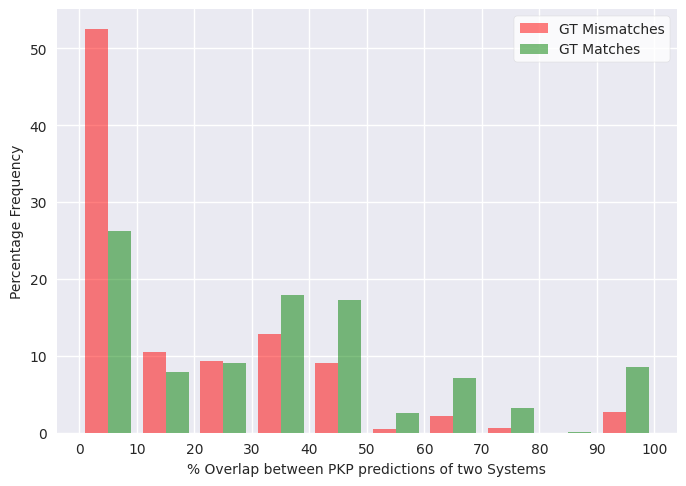

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


# xaxis = 'Percentage (%) of overlap between PKP'

# overlap_percent = {xaxis:overlap_percent}
# sns.histplot(data=overlap_percent, x=xaxis, binwidth=10, binrange=(0,100), kde=True, stat='proportion')

# data={'match': overlap_percent_correct, 'mismatch': overlap_percent_wrong, xaxis: overlap_percent_correct}
# sns.histplot(data=data, x=xaxis, binwidth=10, binrange=(0,100), kde=True, stat='proportion')
# sns.set_theme()  # <-- This actually changes the look of plots.
with plt.style.context('seaborn'):
    # pass weights explicitly
    weights_1 = np.ones(len(overlap_percent_wrong)) / len(overlap_percent_wrong)
    weights_2 = np.ones(len(overlap_percent_correct)) / len(overlap_percent_correct)
    # print(weights_1)
    plt.hist([overlap_percent_wrong, overlap_percent_correct], color=['r','g'], weights=[weights_1, weights_2], histtype='bar', stacked=False, alpha=0.5, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, symbol=False))
    plt.xticks(ticks=list(range(0,101,10)))
    # plt.yticks(ticks=np.arange(0,1.1,0.1))
    plt.xlabel('% Overlap between PKP predictions of two Systems')
    plt.ylabel('Percentage Frequency')
    plt.legend(['GT Mismatches','GT Matches'], frameon=True, facecolor='white')
# sns.histplot([overlap_percent_overall, overlap_percent_correct], color=['r','g'], alpha=0.9, binwidth=10, binrange=(0,100))
plt.show()


In [73]:
# 1/10000

# Absent KP Plot

In [74]:
# plot for absent
import numpy as np
# x-axis datapoints
# y-axis % of kps that have an intersection
num = [len(x&y) for x, y in zip(kpaug_akps, kpbase_akps)]
num_correct = [len(x&y&z) for x, y, z in zip(kpaug_akps, kpbase_akps, kpbase_gakps)]
num_wrong = [len(x&y&((x|y)-z)) for x, y, z in zip(kpaug_akps, kpbase_akps, kpbase_gakps)]
den = [len(x|y) for x, y, _ in zip(kpaug_akps, kpbase_akps, kpbase_gakps)]

overlap_percent_correct = [(x/(y+1e-08))*100 for x, y in zip(num_correct, den)]
overlap_percent_wrong = [(x/(y+1e-08))*100 for x, y in zip(num_wrong, den)]
overlap_percent_overall = [(x/(y+1e-08))*100 for x, y in zip(num, den)]
# print(num_correct)
# print(num_wrong)
# print(overlap_percent)
# num_ = np.cumsum(num)
# den_ = np.cumsum(den)
# for x, y, z in zip(overlap_percent_correct, overlap_percent_wrong, overlap_percent_overall):
#     print(x, y, z)

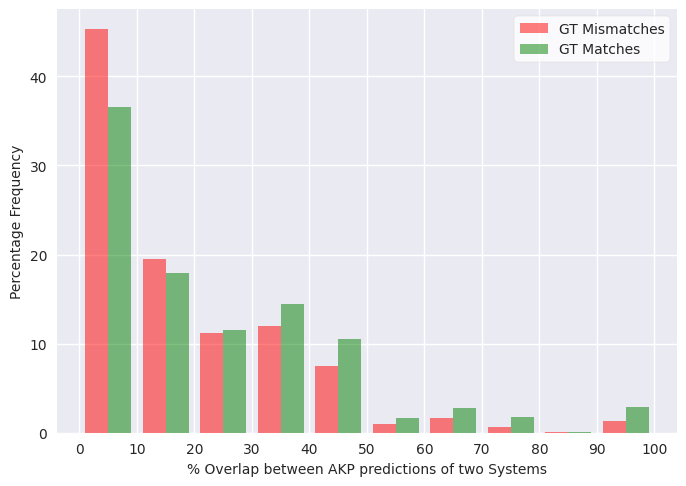

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
# xaxis = 'Percentage (%) of overlap between AKP'

# overlap_percent = {xaxis:overlap_percent}
# sns.histplot(data=overlap_percent, x=xaxis, binwidth=10, binrange=(0,100), kde=True, stat='proportion')

data={'match': overlap_percent_correct, 'mismatch': overlap_percent_wrong, xaxis: overlap_percent_correct}
# sns.histplot(data=data, x=xaxis, binwidth=10, binrange=(0,100), kde=True, stat='proportion')
# sns.set_theme()  # <-- This actually changes the look of plots.
with plt.style.context('seaborn'):
    weights_1 = np.ones(len(overlap_percent_wrong)) / len(overlap_percent_wrong)
    weights_2 = np.ones(len(overlap_percent_correct)) / len(overlap_percent_correct)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, symbol=False, decimals=0))
    

    plt.hist([overlap_percent_wrong, overlap_percent_correct], color=['r','g'], weights=[weights_1, weights_2], histtype='bar', stacked=False, alpha=0.5, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.xticks(ticks=list(range(0,101,10)))
    # plt.yticks(ticks=np.arange(0,1.1,0.1))
    plt.xlabel('% Overlap between AKP predictions of two Systems')
    plt.ylabel('Percentage Frequency')
    plt.legend(['GT Mismatches','GT Matches'], frameon=True, facecolor='white')
plt.show()
# sns.histplot([overlap_percent_overall, overlap_percent_correct], color=['r','g'], alpha=0.9, binwidth=10, binrange=(0,100))

In [1]:
import pandas as pd
df = pd.read_csv('/home/thomased/work/codebase/coopsummer2023/Project/checkpoints/phase3_exp/abstractive_models/bertbase_seq2seq_kp20k/metrics_4(Greedy)_significance')
df

,dataset,F1@M,F1@K,F1@O
0,kp20k,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999999850000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999999850000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999999850000..."
1,krapivin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39999999..."
2,inspec,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,semeval,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18181817...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18181817...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18181817..."
4,nus,"[0.0, 0.0, 0.09090908917355373, 0.0, 0.0, 0.49...","[0.0, 0.0, 0.09090908917355373, 0.0, 0.0, 0.49...","[0.0, 0.0, 0.09090908917355373, 0.0, 0.0, 0.49..."


In [2]:
import json
for ind, x in df.iterrows():
    a = json.loads(x['F1@M'])
    b = json.loads(x['F1@K'])
    c = json.loads(x['F1@O'])
    print(len(a), len(b), len(c))

92 92 92
92 92 92
78 78 78
99 99 99
93 93 93
